## Goal:
Show the development of government expenditure / revenue over 10 years.

## Issues:
1. no unique index/identifier. 
2. Title, chapter and individual plan (col: "Tit.", "Kap.", "Epl.") are together unique, but not constant (consistent) over the years.
3. Names of bookings (col: "Zweckbestimmung") are also not constant. 

Summarized: It is impossible to track all entries (rows) over 10 years, the number of rows per year varies. But as many entries as possible should be mapped.

## Solutions:
1. Make a new id column from col: Tit., chap., epl..
2. Try to include the purpose or other columns. In the next chapter, this is attempted via embeddings of an encoder.
3. In this notebook at least the problem is identified: e.g. the entry “Arbeitslosengeld II” changes the name as well as the Kap. and Tit. over the years. 

One approach would be to manually create a mapper dict (10 largest bookings are roughly 50% of the budget). 
Instead, an NLP approach is used in the next notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
#import requests
#import txtai

# Functions

In [2]:
def drop_nan(df):
    col_ist = [col for col in df.columns if col.startswith("Ist")][0]
    df = df.dropna(subset=col_ist, ignore_index=True)
    df = df[df[col_ist] > 1000]
    df[["Epl.", "Kap.", "Tit."]] = df[["Epl.", "Kap.", "Tit."]].astype(int, copy=False)
    df = df[["Epl.", "Kap.", "Tit.", col_ist, "Zweckbestimmung"]]
    return df

In [3]:
def make_id_col(df):
    df["id"] = df["Tit."].astype(str).str.zfill(5) + df["Epl."].astype(str).str.zfill(2) + df["Kap."].astype(str).str.zfill(2)
    df = df.drop(["Epl.", "Kap.", "Tit."], axis=1)
    return df

In [4]:
def pipeline(range_years):
    df_result = pd.read_excel(f"data/HR20{range_years[0]}.xlsx")
    df_result = make_id_col(drop_nan(df_result))[["id", "Zweckbestimmung", f"Ist 20{range_years[0]}"]]
    for year in range(range_years[0]+1, range_years[1]):
        df_i = pd.read_excel(f"data/HR20{year}.xlsx")
        df_i = drop_nan(df_i)
        df_i = make_id_col(df_i).drop("Zweckbestimmung", axis=1)
        df_result = pd.merge(df_result, df_i, on='id', how="inner")
    return df_result

In [7]:
df_test = pd.read_excel("data/data_raw/HR2012.xlsx")
df_test_2 = pd.read_excel("data/data_raw/HR2022.xlsx")

# First Look at Data

In [8]:
df_test

,Epl.,Kap.,Tit.,Fkt.,Flex.,Tgr.,E/A,Zweckbestimmung,Ist 2012,Umsatzgruppe (Hauptgruppe/Titelgruppe),Seite
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Bundespräsident und Bundespräsidialamt,NaN,NaN,NaN
1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,Bundespräsident,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Einnahmen,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Übrige Einnahmen,NaN,NaN,NaN
4,1.0,1.0,23201,193.0,NaN,NaN,E,Beteiligung der Länder an der Deutschen Künstl...,1.083796e+06,Übrige Einnahmen,67.0
...,...,...,...,...,...,...,...,...,...,...,...
8288,60.0,67.0,63641,229.0,NaN,4.0,A,Erstattung von Verwaltungskosten an die Deutsc...,1.285253e+07,Leistungen nach dem Anspruchs- und Anwartschaf...,1454.0
8289,60.0,67.0,63642,229.0,NaN,4.0,A,Erstattung an Sozialversicherungsträger für Re...,5.746716e+08,Leistungen nach dem Anspruchs- und Anwartschaf...,1454.0
8290,60.0,67.0,63643,229.0,NaN,4.0,A,Erstattung an Sozialversicherungsträger für Re...,7.871757e+08,Leistungen nach dem Anspruchs- und Anwartschaf...,1455.0
8291,60.0,67.0,63644,229.0,NaN,4.0,A,Erstattung an Sozialversicherungsträger für Re...,4.940458e+07,Leistungen nach dem Anspruchs- und Anwartschaf...,1455.0


In [9]:
df_test.dtypes

Epl.                                      float64
Kap.                                      float64
Tit.                                       object
Fkt.                                      float64
Flex.                                      object
Tgr.                                      float64
E/A                                        object
Zweckbestimmung                            object
Ist 2012                                  float64
Umsatzgruppe (Hauptgruppe/Titelgruppe)     object
Seite                                     float64
dtype: object

In [10]:
df_test = drop_nan(df_test)
df_test = make_id_col(df_test)

df_test_2 = drop_nan(df_test_2)
df_test_2 = make_id_col(df_test_2)

In [11]:
df_test

,Ist 2012,Zweckbestimmung,id
0,1.083796e+06,Beteiligung der Länder an der Deutschen Künstl...,232010101
1,1.988409e+05,Bezüge des Bundespräsidenten,421010101
2,6.793548e+04,Aufwandsgeld,421020101
4,5.849732e+05,Außergewöhnlicher Aufwand aus dienstlicher Ver...,529010101
6,1.347210e+06,"Übernahme von Patenschaften, Ausgaben aus beso...",681010101
...,...,...,...
6457,1.285253e+07,Erstattung von Verwaltungskosten an die Deutsc...,636416067
6458,5.746716e+08,Erstattung an Sozialversicherungsträger für Re...,636426067
6459,7.871757e+08,Erstattung an Sozialversicherungsträger für Re...,636436067
6460,4.940458e+07,Erstattung an Sozialversicherungsträger für Re...,636446067


In [18]:
df_test.shape , df_test_2.shape

((5401, 3), (5241, 3))

In [19]:
pd.merge(df_test, df_test_2, on='id', how="inner")["Ist 2022"].sum() / df_test_2["Ist 2022"].sum(), pd.merge(df_test, df_test_2, on='id', how="inner")["Ist 2012"].sum() / df_test["Ist 2012"].sum()

(0.5869674806201383, 0.601035666135275)

In [20]:
pd.merge(df_test, df_test_2, on='id').shape[0], pd.merge(df_test, df_test_2, on='Zweckbestimmung').shape[0]

(1012, 238474)

In [21]:
pd.merge(df_test, df_test_2, on='Zweckbestimmung', how="left").shape[0], pd.merge(df_test, df_test_2, on='Zweckbestimmung', how="right").shape[0]

(239771, 240319)

In [22]:
merged_df = pd.merge(df_test, df_test_2, on='id', how="inner")
merged_df

,Ist 2012,Zweckbestimmung_x,id,Ist 2022,Zweckbestimmung_y
0,1.083796e+06,Beteiligung der Länder an der Deutschen Künstl...,232010101,1.126700e+06,Beteiligung der Länder an der Deutschen Künstl...
1,1.988409e+05,Bezüge des Bundespräsidenten,421010101,2.583531e+05,Bezüge des Bundespräsidenten
2,6.793548e+04,Aufwandsgeld,421020101,7.800000e+04,Aufwandsgeld
3,5.849732e+05,Außergewöhnlicher Aufwand aus dienstlicher Ver...,529010101,8.905984e+05,Außergewöhnlicher Aufwand aus dienstlicher Ver...
4,1.347210e+06,"Übernahme von Patenschaften, Ausgaben aus beso...",681010101,1.231512e+06,"Übernahme von Patenschaften, Ausgaben aus beso..."
...,...,...,...,...,...
1007,1.285253e+07,Erstattung von Verwaltungskosten an die Deutsc...,636416067,2.562377e+06,Erstattung von Verwaltungskosten an die Deutsc...
1008,5.746716e+08,Erstattung an Sozialversicherungsträger für Re...,636426067,8.761600e+08,Erstattung an Sozialversicherungsträger für Re...
1009,7.871757e+08,Erstattung an Sozialversicherungsträger für Re...,636436067,8.587050e+08,Erstattung an Sozialversicherungsträger für Re...
1010,4.940458e+07,Erstattung an Sozialversicherungsträger für Re...,636446067,7.361706e+07,Erstattung an Sozialversicherungsträger für Re...


In [23]:
merged_df.sort_values("Ist 2012", ascending=False).iloc[:5]

,Ist 2012,Zweckbestimmung_x,id,Ist 2022,Zweckbestimmung_y
909,7.608407e+10,Umsatzsteuer,015016001,9.241173e+10,Umsatzsteuer
905,6.313621e+10,Lohnsteuer,011016001,9.656430e+10,Lohnsteuer
914,3.522622e+10,"Energiesteuer (sonstiges Aufkommen, ohne das i...",031036001,2.938877e+10,"Energiesteuer (sonstiges Aufkommen, ohne das i..."
910,2.788054e+10,Einfuhrumsatzsteuer,016016001,4.040062e+10,Einfuhrumsatzsteuer
897,2.323186e+10,Zinsen für Bundesanleihen,575013205,1.248070e+10,Zinsen für Bundesanleihen


In [24]:
merged_df.sort_values("Ist 2022", ascending=False).head(5).reset_index()

,index,Ist 2012,Zweckbestimmung_x,id,Ist 2022,Zweckbestimmung_y
0,892,2.248003e+10,Einnahmen aus Krediten vom Kreditmarkt,325113201,1.154416e+11,Einnahmen aus Krediten vom Kreditmarkt
1,905,6.313621e+10,Lohnsteuer,011016001,9.656430e+10,Lohnsteuer
2,909,7.608407e+10,Umsatzsteuer,015016001,9.241173e+10,Umsatzsteuer
3,910,2.788054e+10,Einfuhrumsatzsteuer,016016001,4.040062e+10,Einfuhrumsatzsteuer
4,906,1.583799e+10,Veranlagte Einkommensteuer,012016001,3.289996e+10,Veranlagte Einkommensteuer


In [25]:
merged_df.sort_values("Ist 2022", ascending=False).head(30)["Ist 2022"].sum() / df_test_2["Ist 2022"].sum()

0.5450717556784107

# Try to mapp more rows with col "Zweckbestimmung"

In [59]:
def make_id_col(df):
    df["id"] = df["Tit."].astype(str).str.zfill(5) + df["Epl."].astype(str).str.zfill(2) + df["Kap."].astype(str).str.zfill(2)
    #df = df.drop(["Epl.", "Kap.", "Tit."], axis=1)
    return df

def make_id_col(df, zahlen_dict):
    df["id_help"] = df["Tit."].astype(str).str.zfill(5) + df["Epl."].astype(str).str.zfill(2) + df["Kap."].astype(str).str.zfill(2)
    df["id"] = df["id_help"].apply(map_numbers) + df["Zweckbestimmung"]
    #df["id"] = df["Zweckbestimmung"].astype(str) +" "+ df["Tit."].astype(str).str.zfill(5) + df["Epl."].astype(str).str.zfill(2) + df["Kap."].astype(str).str.zfill(2)
    #df = df.drop(["Epl.", "Kap.", "Tit."], axis=1)
    return df

def map_numbers(string):
    string = " ".join([zahlen_dict[int(dig)] for dig in str(string)]) + " "
    return string

zahlen = "null, eins, zwei, drei, vier, fünf, sechs, sieben, acht, neun".split(", ")
zahlen_dict = { k:v for k,v in zip(range(10), zahlen)}
zahlen_dict

In [60]:
df_test = pd.read_excel("data/HR2012.xlsx")
df_test_2 = pd.read_excel("data/HR2022.xlsx")

In [93]:
# For some reason, drop_nan only reset index if its called two times
df_test = drop_nan(df_test)
df_test = drop_nan(df_test)
df_test = make_id_col(df_test)

df_test_2 = drop_nan(df_test_2)
df_test_2 = drop_nan(df_test_2)
df_test_2 = make_id_col(df_test_2)

In [94]:
df_test_2

,Epl.,Kap.,Tit.,Ist 2022,Zweckbestimmung,id
0,1,1,23201,1.126700e+06,Beteiligung der Länder an der Deutschen Künstl...,232010101
1,1,1,52901,8.905984e+05,Außergewöhnlicher Aufwand aus dienstlicher Ver...,529010101
2,1,1,68101,1.231512e+06,"Übernahme von Patenschaften, Ausgaben aus beso...",681010101
3,1,1,68401,3.421900e+06,Deutsche Künstlerhilfe,684010101
4,1,1,42101,2.583531e+05,Bezüge des Bundespräsidenten,421010101
...,...,...,...,...,...,...
5236,60,67,63641,2.562377e+06,Erstattung von Verwaltungskosten an die Deutsc...,636416067
5237,60,67,63642,8.761600e+08,Erstattung an Sozialversicherungsträger für Re...,636426067
5238,60,67,63643,8.587050e+08,Erstattung an Sozialversicherungsträger für Re...,636436067
5239,60,67,63644,7.361706e+07,Erstattung an Sozialversicherungsträger für Re...,636446067


In [95]:
"111268112 Arbeitslosengeld II"

'111268112 Arbeitslosengeld II'

In [96]:
idx_arbeit = df_test[df_test["Zweckbestimmung"] == "Arbeitslosengeld II"].index
df_test.iloc[idx_arbeit[0]]

Epl.                                11
Kap.                                12
Tit.                             68112
Ist 2012                18951335517.59
Zweckbestimmung    Arbeitslosengeld II
id                           681121112
Name: 3058, dtype: object

In [98]:
df_test_2[df_test_2["Zweckbestimmung"] == "Arbeitslosengeld II"]["id"].iloc[0]

'681121101'

In [115]:
df_test[df_test["id"].str.startswith("68112")]#.iloc[0,-1]

,Epl.,Kap.,Tit.,Ist 2012,Zweckbestimmung,id
594,5,2,68112,3.248134e+05,Einmalige Bewilligungen für ehemalige Bedienst...,681120502
1418,6,40,68112,3.761538e+06,Eingliederungshilfen und Unterstützungsleistungen,681120640
3058,11,12,68112,1.895134e+10,Arbeitslosengeld II,681121112
5166,30,2,68112,1.751945e+07,Nationales Stipendienprogramm,681123002


In [77]:
df_test_2[df_test_2["Tit."] == 68112]

,Epl.,Kap.,Tit.,Ist 2022,Zweckbestimmung,id
691,5,1,68112,6.443541e+04,Einmalige Bewilligungen für ehemalige Bedienst...,681120501
3226,11,1,68112,2.227577e+10,Arbeitslosengeld II,681121101
6234,30,2,68112,3.682207e+07,Deutschlandstipendium,681123002


In [78]:
df_test[df_test["Tit."] == 68112]

,Epl.,Kap.,Tit.,Ist 2012,Zweckbestimmung,id
737,5,2,68112,3.248134e+05,Einmalige Bewilligungen für ehemalige Bedienst...,681120502
1702,6,40,68112,3.761538e+06,Eingliederungshilfen und Unterstützungsleistungen,681120640
3676,11,12,68112,1.895134e+10,Arbeitslosengeld II,681121112
6175,30,2,68112,1.751945e+07,Nationales Stipendienprogramm,681123002


In [79]:
df_test_2["id"].tolist()[661]

'812120512'

In [80]:
111268112 Arbeitslosengeld II, 2.227577e+10

SyntaxError: invalid syntax (206908936.py, line 1)

In [81]:
2.227577e+10

22275770000.0

In [82]:
df_test_2[df_test_2["Tit."] == 68112]

,Epl.,Kap.,Tit.,Ist 2022,Zweckbestimmung,id
691,5,1,68112,6.443541e+04,Einmalige Bewilligungen für ehemalige Bedienst...,681120501
3226,11,1,68112,2.227577e+10,Arbeitslosengeld II,681121101
6234,30,2,68112,3.682207e+07,Deutschlandstipendium,681123002


In [83]:
111268112 Arbeitslosengeld II, 

SyntaxError: invalid syntax (2094286729.py, line 1)

In [84]:
merged_df = pd.merge(df_test, df_test_2, on='Zweckbestimmung', how="left")
merged_df[merged_df["Tit._x"] == 68112]

,Epl._x,Kap._x,Tit._x,Ist 2012,Zweckbestimmung,id_x,Epl._y,Kap._y,Tit._y,Ist 2022,id_y
26127,5,2,68112,3.248134e+05,Einmalige Bewilligungen für ehemalige Bedienst...,681120502,5.0,1.0,68112.0,6.443541e+04,681120501
67540,6,40,68112,3.761538e+06,Eingliederungshilfen und Unterstützungsleistungen,681120640,6.0,3.0,68122.0,1.265323e+06,681220603
148084,11,12,68112,1.895134e+10,Arbeitslosengeld II,681121112,11.0,1.0,68112.0,2.227577e+10,681121101
238016,30,2,68112,1.751945e+07,Nationales Stipendienprogramm,681123002,NaN,NaN,NaN,NaN,NaN


In [85]:
merged_df = pd.merge(df_test, df_test_2, on='Zweckbestimmung', how="right")
merged_df[merged_df["Tit._y"] == 68112]

,Epl._x,Kap._x,Tit._x,Ist 2012,Zweckbestimmung,id_x,Epl._y,Kap._y,Tit._y,Ist 2022,id_y
24727,5.0,2.0,68112.0,3.248134e+05,Einmalige Bewilligungen für ehemalige Bedienst...,681120502,5,1,68112,6.443541e+04,681120501
128108,11.0,12.0,68112.0,1.895134e+10,Arbeitslosengeld II,681121112,11,1,68112,2.227577e+10,681121101
236035,NaN,NaN,NaN,NaN,Deutschlandstipendium,NaN,30,2,68112,3.682207e+07,681123002


In [86]:
merged_df = pd.merge(df_test_2, df_test, on='Zweckbestimmung', how="outer")
merged_df[merged_df["Tit._x"] == 68112]

,Epl._x,Kap._x,Tit._x,Ist 2022,Zweckbestimmung,id_x,Epl._y,Kap._y,Tit._y,Ist 2012,id_y
235714,5.0,1.0,68112.0,6.443541e+04,Einmalige Bewilligungen für ehemalige Bedienst...,681120501,5.0,2.0,68112.0,3.248134e+05,681120502
238927,11.0,1.0,68112.0,2.227577e+10,Arbeitslosengeld II,681121101,11.0,12.0,68112.0,1.895134e+10,681121112
240063,30.0,2.0,68112.0,3.682207e+07,Deutschlandstipendium,681123002,NaN,NaN,NaN,NaN,NaN


In [87]:
df_test_2[df_test_2["Tit."] == 68112]

,Epl.,Kap.,Tit.,Ist 2022,Zweckbestimmung,id
691,5,1,68112,6.443541e+04,Einmalige Bewilligungen für ehemalige Bedienst...,681120501
3226,11,1,68112,2.227577e+10,Arbeitslosengeld II,681121101
6234,30,2,68112,3.682207e+07,Deutschlandstipendium,681123002


In [88]:
df_test[df_test["Tit."] == 68112]

,Epl.,Kap.,Tit.,Ist 2012,Zweckbestimmung,id
737,5,2,68112,3.248134e+05,Einmalige Bewilligungen für ehemalige Bedienst...,681120502
1702,6,40,68112,3.761538e+06,Eingliederungshilfen und Unterstützungsleistungen,681120640
3676,11,12,68112,1.895134e+10,Arbeitslosengeld II,681121112
6175,30,2,68112,1.751945e+07,Nationales Stipendienprogramm,681123002


In [89]:
df_test_2["id"].tolist()

['232010101',
 '529010101',
 '681010101',
 '684010101',
 '421010101',
 '421020101',
 '232570111',
 '542010111',
 '981030111',
 '431570111',
 '432570111',
 '434570111',
 '446570111',
 '424010111',
 '441010111',
 '443010111',
 '452020111',
 '526010111',
 '526020111',
 '545010111',
 '634030111',
 '119990112',
 '132010112',
 '685010112',
 '981030112',
 '422010112',
 '427090112',
 '428010112',
 '453010112',
 '511010112',
 '514010112',
 '517010112',
 '518010112',
 '519010112',
 '525010112',
 '527010112',
 '532010112',
 '532040112',
 '532050112',
 '539990112',
 '711010112',
 '812010112',
 '812020112',
 '132010113',
 '282090113',
 '518020113',
 '529010113',
 '422010113',
 '427090113',
 '428010113',
 '441010113',
 '443010113',
 '511010113',
 '518010113',
 '532010113',
 '539990113',
 '634030113',
 '812020113',
 '232570211',
 '529010211',
 '542010211',
 '981030211',
 '431570211',
 '432570211',
 '434570211',
 '443570211',
 '446570211',
 '632570211',
 '424010211',
 '441010211',
 '443010211',
 '4430

In [90]:
#embedding_model_name = "neuml/pubmedbert-base-embeddings"
#embeddings_short = txtai.Embeddings(path=embedding_model_name, content=False)
#embeddings_short.index(zip(codes["DIAGNOSIS CODE"], codes["SHORT DESCRIPTION"]))
#embeddings_short.save("/data/embeddings/embeddings_short")
#results_short = short_desc_index.batchsearch(flattened_predicted_diag_names, limit=1)

In [15]:
#embedding_model_name = "neuml/pubmedbert-base-embeddings"
embeddings_short = txtai.Embeddings()

In [16]:
embeddings_short.index(df_test_2["id"].tolist())

: 

In [ ]:
embeddings_short = txtai.Embeddings().load("/data/embeddings/embeddings_short")

In [ ]:
embeddings_short.save("/data/embeddings/embeddings_short")

In [ ]:
embeddings_short = txtai.Embeddings(path=embedding_model_name, content=False)

# Make pipeline

In [55]:
def make_id_col(df):
    df["id"] = df["Tit."].astype(str).str.zfill(5) + df["Epl."].astype(str).str.zfill(2) + df["Kap."].astype(str).str.zfill(2)
    df = df.drop(["Epl.", "Kap.", "Tit."], axis=1)
    return df

In [56]:
%%time
df_res = pipeline((12,24))

C:\Users\sebas\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


CPU times: total: 51.3 s
Wall time: 51.5 s


In [57]:
df_res = df_res.sort_values("Ist 2023", ascending=False)
df_res

,id,Zweckbestimmung,Ist 2012,Ist 2013,Ist 2014,Ist 2015,Ist 2016,Ist 2017,Ist 2018,Ist 2019,Ist 2020,Ist 2021,Ist 2022,Ist 2023
808,015016001,Umsatzsteuer,7.608407e+10,7.917711e+10,8.246040e+10,8.309309e+10,8.203658e+10,8.647531e+10,8.705545e+10,8.953635e+10,7.255127e+10,8.463254e+10,9.241173e+10,1.010134e+11
804,011016001,Lohnsteuer,6.313621e+10,6.717432e+10,7.141968e+10,7.602806e+10,7.851858e+10,8.312150e+10,8.851997e+10,9.331063e+10,8.907473e+10,9.267056e+10,9.656430e+10,1.003821e+11
809,016016001,Einfuhrumsatzsteuer,2.788054e+10,2.590640e+10,2.613589e+10,2.660053e+10,2.529200e+10,2.832992e+10,2.945726e+10,2.940793e+10,2.184020e+10,2.849295e+10,4.040062e+10,3.743929e+10
813,031036001,"Energiesteuer (sonstiges Aufkommen, ohne das i...",3.522622e+10,3.511706e+10,3.552215e+10,3.600326e+10,3.645493e+10,3.659441e+10,3.675357e+10,3.671889e+10,3.351130e+10,3.310098e+10,2.938877e+10,3.307486e+10
805,012016001,Veranlagte Einkommensteuer,1.583799e+10,1.796892e+10,1.938512e+10,2.064707e+10,2.287918e+10,2.525631e+10,2.567763e+10,2.707763e+10,2.506692e+10,3.074644e+10,3.289996e+10,3.119034e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,124011214,"Einnahmen aus Vermietung, Verpachtung und Nutzung",2.286965e+05,1.702515e+05,1.643971e+05,1.297399e+05,8.020474e+04,1.282176e+04,1.258176e+04,1.258176e+04,1.258176e+04,1.258176e+04,1.258176e+04,4.807330e+03
369,711010915,"Kleine Neu-, Um- und Erweiterungsbauten",1.615646e+06,1.513405e+06,1.365480e+06,2.616001e+06,3.474465e+06,1.876919e+06,8.582613e+05,6.383259e+05,8.080972e+05,6.709189e+04,4.968671e+05,4.247010e+03
853,281016003,Einnahmen aus Rückforderungen wegen unrechtmäß...,2.735203e+04,2.284789e+05,7.993039e+04,3.159710e+04,2.719166e+04,2.587008e+04,2.572460e+03,2.652272e+05,9.208910e+03,1.272041e+04,1.675420e+03,2.999370e+03
411,547410916,Nicht aufteilbare sächliche Verwaltungsausgaben,7.881745e+05,5.623443e+05,2.892366e+05,7.800886e+04,4.933282e+04,2.389342e+04,7.392067e+04,7.495090e+04,2.119562e+04,1.856748e+04,2.124640e+03,2.618500e+03


In [19]:
df_res.to_csv("data/HR10y_on_id.csv")

In [58]:
df_res.iloc[3:13]

,id,Zweckbestimmung,Ist 2012,Ist 2013,Ist 2014,Ist 2015,Ist 2016,Ist 2017,Ist 2018,Ist 2019,Ist 2020,Ist 2021,Ist 2022,Ist 2023
813,031036001,"Energiesteuer (sonstiges Aufkommen, ohne das i...",3.522622e+10,3.511706e+10,3.552215e+10,3.600326e+10,3.645493e+10,3.659441e+10,3.675357e+10,3.671889e+10,3.351130e+10,3.310098e+10,2.938877e+10,3.307486e+10
805,012016001,Veranlagte Einkommensteuer,1.583799e+10,1.796892e+10,1.938512e+10,2.064707e+10,2.287918e+10,2.525631e+10,2.567763e+10,2.707763e+10,2.506692e+10,3.074644e+10,3.289996e+10,3.119034e+10
807,014016001,Körperschaftsteuer,8.467229e+09,9.753803e+09,1.002201e+10,9.791505e+09,1.372097e+10,1.462944e+10,1.671272e+10,1.600665e+10,1.213384e+10,2.106197e+10,2.316691e+10,2.242582e+10
806,013016001,Nicht veranlagte Steuern vom Ertrag (ohne das ...,1.002753e+10,8.630587e+09,8.712184e+09,8.967812e+09,9.730919e+09,1.045070e+10,1.159203e+10,1.172445e+10,1.076111e+10,1.369546e+10,1.631321e+10,1.822084e+10
820,036026001,Versicherungsteuer,1.113797e+10,1.155277e+10,1.204621e+10,1.241947e+10,1.276322e+10,1.326932e+10,1.377878e+10,1.413591e+10,1.455341e+10,1.497988e+10,1.567192e+10,1.685067e+10
815,032026001,Tabaksteuer,1.414345e+10,1.381994e+10,1.461174e+10,1.492092e+10,1.418606e+10,1.439883e+10,1.433901e+10,1.425683e+10,1.465092e+10,1.473252e+10,1.422942e+10,1.467181e+10
797,575013205,Zinsen für Bundesanleihen,2.323186e+10,2.428831e+10,2.262651e+10,2.148366e+10,2.080560e+10,1.868023e+10,1.756761e+10,1.589691e+10,1.622253e+10,1.379658e+10,1.248070e+10,1.302724e+10
822,038016001,Kfz-Steuer,8.442660e+09,8.490321e+09,8.501012e+09,8.804826e+09,8.952083e+09,8.947729e+09,9.046955e+09,9.372266e+09,9.526381e+09,9.546430e+09,9.498884e+09,9.514262e+09
845,685016002,Zuschuss an die Postbeamtenversorgungskasse,6.716500e+09,6.930500e+09,7.207700e+09,7.400500e+09,7.461900e+09,7.885000e+09,8.129500e+09,8.384000e+09,8.468100e+09,8.696400e+09,8.865300e+09,9.318500e+09
647,423011403,Bezüge und Nebenleistungen der Berufssoldatinn...,6.084406e+09,6.147241e+09,6.201289e+09,6.297758e+09,6.366812e+09,6.646991e+09,6.943968e+09,7.317353e+09,7.641803e+09,7.757397e+09,7.893807e+09,8.296840e+09


In [59]:
df_plot = df_res.iloc[20:25,1:].set_index("Zweckbestimmung").T.copy()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: >

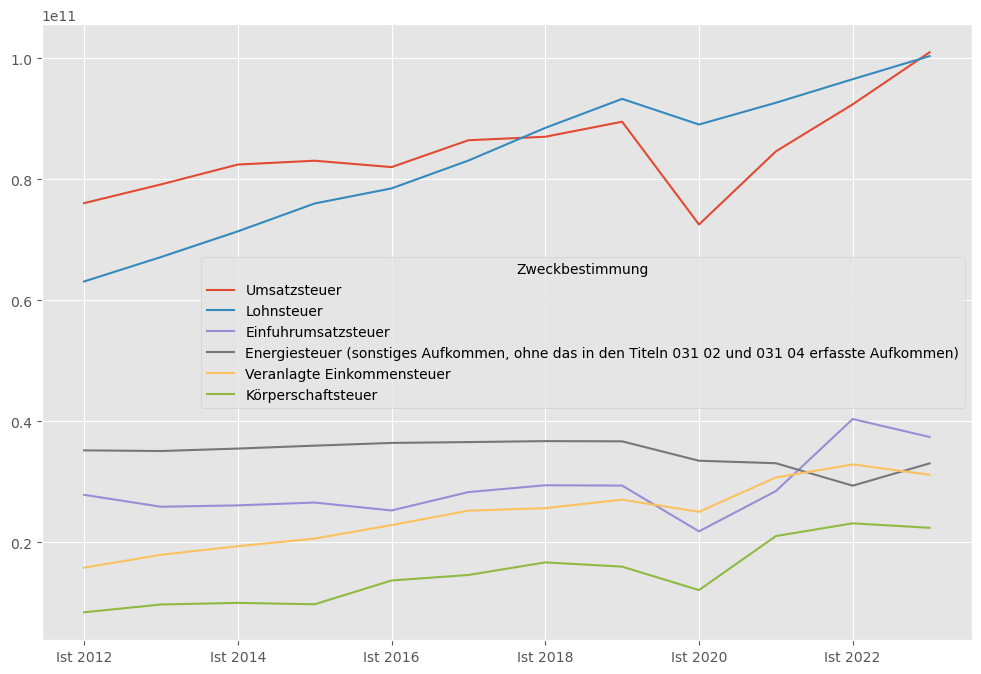

In [60]:
df_plot = df_res.iloc[:6,1:].set_index("Zweckbestimmung").T.copy()
plt.figure(figsize=(12, 8))
plt.style.use('ggplot')
plt.legend(fontsize=12, loc="best")
df_plot.plot(ax=plt.gca())
#plt.show()

C:\Users\sebas\AppData\Local\Temp\ipykernel_13952\1400926398.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')  # You can choose other styles like 'ggplot', 'fivethirtyeight', etc.


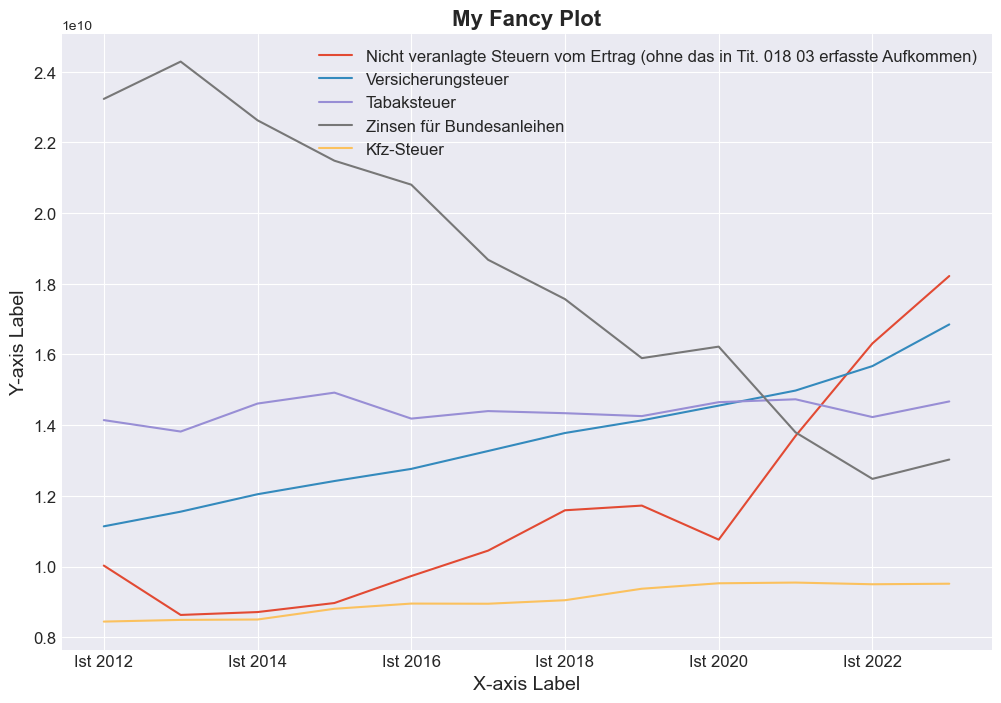

In [61]:
df_plot = df_res.iloc[6:11,1:].set_index("Zweckbestimmung").T.copy()
# Setting a larger figure size and applying a style
plt.figure(figsize=(12, 8))  # Adjust the width and height as needed
plt.style.use('seaborn-darkgrid')  # You can choose other styles like 'ggplot', 'fivethirtyeight', etc.

# Plotting the DataFrame
df_plot.plot(ax=plt.gca())  # Use the current Axes to apply size and style
plt.title("My Fancy Plot", fontsize=16, fontweight='bold')  # Adding a title
plt.xlabel("X-axis Label", fontsize=14)  # Customizing the x-axis label
plt.ylabel("Y-axis Label", fontsize=14)  # Customizing the y-axis label

# Customizing ticks and legend
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc="best")  # Position the legend automatically

# Show the plot
plt.show()

In [114]:
df_plot = df_res.iloc[11:20,1:].set_index("Zweckbestimmung").T.copy()
# Setting a larger figure size and applying a style
plt.figure(figsize=(12, 8))  # Adjust the width and height as needed
plt.style.use('seaborn-darkgrid')  # You can choose other styles like 'ggplot', 'fivethirtyeight', etc.

# Plotting the DataFrame
df_plot.plot(ax=plt.gca())  # Use the current Axes to apply size and style
plt.title("My Fancy Plot", fontsize=16, fontweight='bold')  # Adding a title
plt.xlabel("X-axis Label", fontsize=14)  # Customizing the x-axis label
plt.ylabel("Y-axis Label", fontsize=14)  # Customizing the y-axis label

# Customizing ticks and legend
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=8, loc="best")  # Position the legend automatically

# Show the plot
plt.show()
df_plot.T

NameError: name 'df_res' is not defined

C:\Users\sebas\AppData\Local\Temp\ipykernel_13952\970360921.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')  # You can choose other styles like 'ggplot', 'fivethirtyeight', etc.


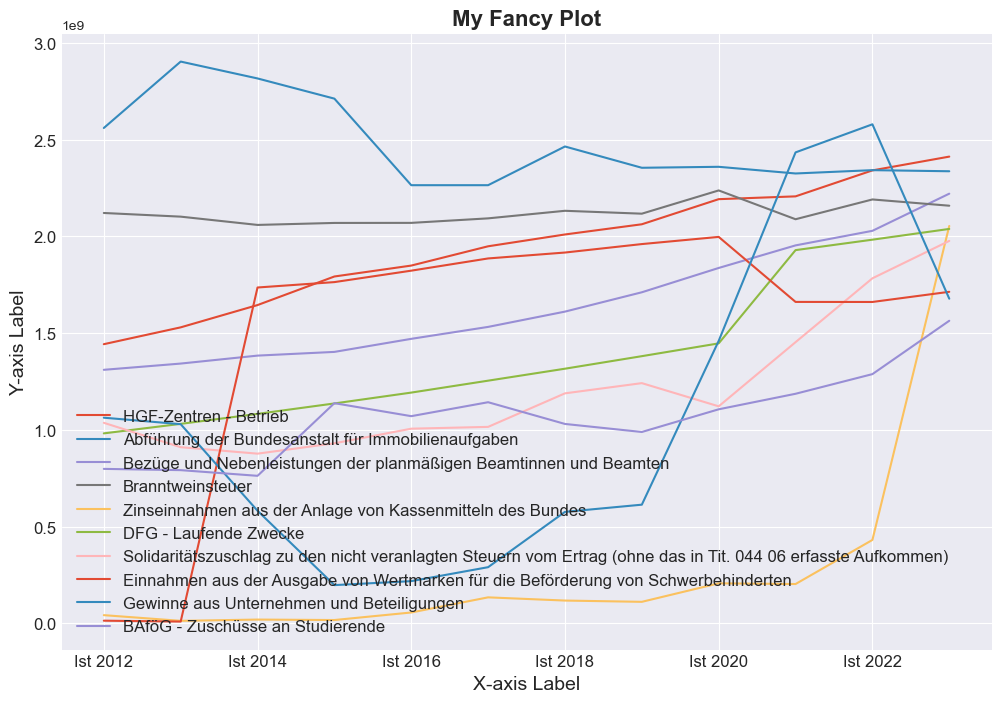

,Ist 2012,Ist 2013,Ist 2014,Ist 2015,Ist 2016,Ist 2017,Ist 2018,Ist 2019,Ist 2020,Ist 2021,Ist 2022,Ist 2023
Zweckbestimmung,,,,,,,,,,,,
HGF-Zentren - Betrieb,1.443339e+09,1.530316e+09,1.645496e+09,1.793155e+09,1.849586e+09,1.949246e+09,2.010320e+09,2.063034e+09,2.192763e+09,2.207249e+09,2.341454e+09,2.412682e+09
Abführung der Bundesanstalt für Immobilienaufgaben,2.560636e+09,2.903779e+09,2.816630e+09,2.712277e+09,2.265000e+09,2.265000e+09,2.465000e+09,2.355000e+09,2.360000e+09,2.325530e+09,2.342690e+09,2.337000e+09
Bezüge und Nebenleistungen der planmäßigen Beamtinnen und Beamten,1.310871e+09,1.343151e+09,1.384291e+09,1.403466e+09,1.470943e+09,1.532645e+09,1.611648e+09,1.711576e+09,1.837218e+09,1.953884e+09,2.029157e+09,2.221172e+09
Branntweinsteuer,2.121386e+09,2.102421e+09,2.059656e+09,2.069929e+09,2.070231e+09,2.093589e+09,2.132679e+09,2.117756e+09,2.237900e+09,2.089038e+09,2.191282e+09,2.158963e+09
Zinseinnahmen aus der Anlage von Kassenmitteln des Bundes,4.301396e+07,1.360465e+07,2.016479e+07,1.779751e+07,5.679460e+07,1.350004e+08,1.184222e+08,1.118618e+08,2.074604e+08,2.038063e+08,4.316888e+08,2.054391e+09
DFG - Laufende Zwecke,9.824220e+08,1.031543e+09,1.083178e+09,1.137082e+09,1.193160e+09,1.254777e+09,1.316612e+09,1.381398e+09,1.447480e+09,1.929402e+09,1.983378e+09,2.038971e+09
Solidaritätszuschlag zu den nicht veranlagten Steuern vom Ertrag (ohne das in Tit. 044 06 erfasste Aufkommen),1.037035e+09,9.109145e+08,8.775783e+08,9.311464e+08,1.006601e+09,1.015984e+09,1.189273e+09,1.242050e+09,1.122193e+09,1.453765e+09,1.783771e+09,1.977113e+09
Einnahmen aus der Ausgabe von Wertmarken für die Beförderung von Schwerbehinderten,1.444140e+07,9.774950e+06,1.736281e+09,1.764158e+09,1.823278e+09,1.886428e+09,1.916957e+09,1.960691e+09,1.997736e+09,1.661781e+09,1.661498e+09,1.713997e+09
Gewinne aus Unternehmen und Beteiligungen,1.063455e+09,1.029987e+09,5.824996e+08,1.982438e+08,2.187696e+08,2.909306e+08,5.767884e+08,6.139224e+08,1.460390e+09,2.434473e+09,2.579599e+09,1.678402e+09


In [65]:
df_plot = df_res.iloc[20:30,1:].set_index("Zweckbestimmung").T.copy()
# Setting a larger figure size and applying a style
plt.figure(figsize=(12, 8))  # Adjust the width and height as needed
plt.style.use('seaborn-darkgrid')  # You can choose other styles like 'ggplot', 'fivethirtyeight', etc.

# Plotting the DataFrame
df_plot.plot(ax=plt.gca())  # Use the current Axes to apply size and style
plt.title("My Fancy Plot", fontsize=16, fontweight='bold')  # Adding a title
plt.xlabel("X-axis Label", fontsize=14)  # Customizing the x-axis label
plt.ylabel("Y-axis Label", fontsize=14)  # Customizing the y-axis label

# Customizing ticks and legend
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc="best")  # Position the legend automatically

# Show the plot
plt.show()
df_plot.T

In [ ]:
# 

In [12]:
print("2012")
print("Administrative costs in billion:", df_test[df_test['Zweckbestimmung'].str.contains("Verwaltung")]["Ist 2012"].sum() / 1e9)
df_test[df_test['Zweckbestimmung'].str.contains("Verwaltung")].sort_values("Ist 2012", ascending=False)

2012
Administrative costs in billion: 11.32468303503


,Ist 2012,Zweckbestimmung,id
4470,5.104600e+09,Erstattungen von Verwaltungsausgaben des Bunde...,634011222
3675,4.209093e+09,Verwaltungskosten für die Durchführung der Gru...,636131112
4800,4.642185e+08,Nicht aufteilbare sächliche Verwaltungsausgaben,547811403
4906,3.001170e+08,Erstattung von Verwaltungsausgaben an die Länder,632011412
2134,1.926264e+08,Erstattung von Verwaltungskosten an die Bundes...,636010803
...,...,...,...
2573,2.164360e+03,Vermischte Verwaltungsausgaben,539590913
5621,1.793070e+03,Nicht aufteilbare sächliche Verwaltungsausgaben,547411607
3406,1.564230e+03,Nicht aufteilbare sächliche Verwaltungsausgaben,547111101
68,1.211650e+03,Vermischte Verwaltungsausgaben,539990104


In [113]:
print("2022")
print("Administrative costs in billion:", df_test_2[df_test_2['Zweckbestimmung'].str.contains("Verwaltung")]["Ist 2022"].sum() / 1e9)
df_test_2[df_test_2['Zweckbestimmung'].str.contains("Verwaltung")].sort_values("Ist 2022", ascending=False)

2022
Administrative costs in billion: 17.79898104593


,Epl.,Kap.,Tit.,Ist 2022,Zweckbestimmung,id
2581,11,1,63613,6.007084e+09,Verwaltungskosten für die Durchführung der Gru...,636131101
3266,12,16,63401,5.045810e+09,Erstattungen von Verwaltungsausgaben des Bunde...,634011216
2904,12,1,68212,2.112356e+09,"Ausgaben der ""Die Autobahn GmbH des Bundes"" fü...",682121201
817,6,2,53238,9.698166e+08,Verwaltungsdigitalisierung,532380602
3743,14,8,63201,5.488748e+08,Erstattung von Verwaltungsausgaben an die Länder,632011408
...,...,...,...,...,...,...
169,2,16,53999,2.449120e+03,Vermischte Verwaltungsausgaben,539990216
2155,9,16,54741,2.124640e+03,Nicht aufteilbare sächliche Verwaltungsausgaben,547410916
2669,11,6,54741,1.685740e+03,Nicht aufteilbare sächliche Verwaltungsausgaben,547411106
3501,12,21,81221,1.480880e+03,"Erwerb von Geräten, Ausstattungs- und Ausrüstu...",812211221


In [16]:
df_test[df_test['Zweckbestimmung'] == "Vermischte Verwaltungsausgaben"].sort_values("Ist 2012", ascending=False)

,Ist 2012,Zweckbestimmung,id
4825,17271418.99,Vermischte Verwaltungsausgaben,539991404
2178,7974370.07,Vermischte Verwaltungsausgaben,539990804
4768,6693597.81,Vermischte Verwaltungsausgaben,539991403
1423,6139311.45,Vermischte Verwaltungsausgaben,539990625
1273,2524950.28,Vermischte Verwaltungsausgaben,539290616
...,...,...,...
548,2388.36,Vermischte Verwaltungsausgaben,539990407
4457,2356.20,Vermischte Verwaltungsausgaben,539191221
189,2171.78,Vermischte Verwaltungsausgaben,539990203
2573,2164.36,Vermischte Verwaltungsausgaben,539590913


In [18]:
df_test_2[df_test_2['Zweckbestimmung'] == "Vermischte Verwaltungsausgaben"].sort_values("Ist 2022", ascending=False)

,Ist 2022,Zweckbestimmung,id
4488,30487202.68,Vermischte Verwaltungsausgaben,539991403
4731,25568792.56,Vermischte Verwaltungsausgaben,539991413
2220,17270812.00,Vermischte Verwaltungsausgaben,539990813
1674,9620942.24,Vermischte Verwaltungsausgaben,539090629
4495,7401627.67,Vermischte Verwaltungsausgaben,539191403
...,...,...,...
230,8945.01,Vermischte Verwaltungsausgaben,539990217
399,6978.85,Vermischte Verwaltungsausgaben,539990415
6420,5555.76,Vermischte Verwaltungsausgaben,539293012
216,2449.12,Vermischte Verwaltungsausgaben,539990216
